Тема: Стратификация

Видео лекции:  
https://www.youtube.com/watch?v=n6szBbkTYnY
    
Видео семинара:  
https://www.youtube.com/watch?v=x7ynsWEsti8

# Повторяю семинар №4

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from tqdm import tqdm

In [2]:
# Настройки для красивых графиков
plt.rcParams['font.size'] = 14

## 1. Вероятность больших перекосов внутри страт

In [3]:
N = 1000
n_iter = 10_000

# Генеральная совокупность с 1000 нулей и 1000 единиц
gen = np.concatenate([np.zeros(N), 1 + np.zeros(N)])


sample_sizes = [10, 20, 50, 100, 200, 500]
means = []
for sample_size in sample_sizes:
    sample_means = []
    for _ in range(n_iter):
        sample = np.random.choice(gen, size=sample_size, replace=False)
        sample_means.append(sample.mean())
    means.append(sample_means)

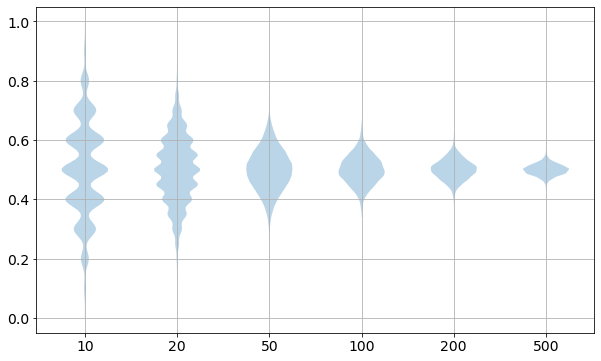

In [4]:
plt.figure(figsize=(10, 6))
ax = plt.subplot()
plt.violinplot(means, positions=range(len(sample_sizes)), showextrema=False);
ax.set_xticks(range(len(sample_sizes)))
ax.set_xticklabels(sample_sizes)
plt.grid()

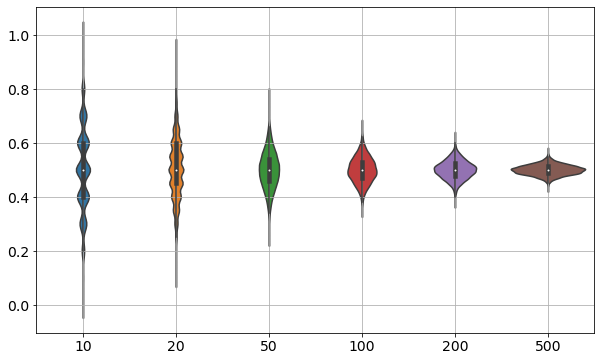

In [5]:
# Такой же график seaborn
plt.figure(figsize=(10, 6))
sns.violinplot(data=means)
ax = plt.subplot()
ax.set_xticks(range(len(sample_sizes)))
ax.set_xticklabels(sample_sizes)
plt.grid()

По графикам видно, что получить большие перекосы в стратах небольшого размера очень вероятно.  
А страты как раз и будут небольшие, т.к. обычно хочется иметь их много

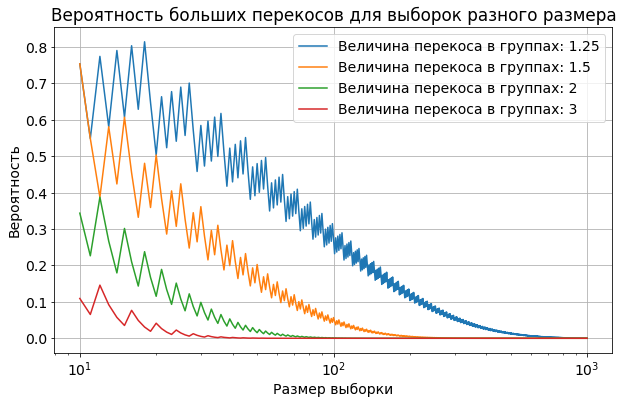

In [6]:
# Оценим численно вероятность больших перекосов
skews = [1.25, 1.5, 2, 3]
sample_sizes = np.arange(10, 1000)

fig = plt.figure(figsize=(10, 6))
for skew in skews:
        
#     dots = []
#     for n in sample_sizes:
#         dots.append(2 * stats.binom.cdf(n / (1 + skew), n, 0.5))

    proba = 2 * stats.binom.cdf(sample_sizes / (1 + skew), sample_sizes, 0.5)
    plt.plot(sample_sizes, proba, label=f"Величина перекоса в группах: {skew}")

plt.title('Вероятность больших перекосов для выборок разного размера')
plt.xlabel('Размер выборки')
plt.ylabel('Вероятность')
plt.xscale('log')
plt.legend()
plt.grid()
    

Из графика видно, что вероятность получить перекос в 1,25 раза (это примерно 55 наблюдений в одной группе и 45 в другой) при рармере выборки = 100 составляет аж 30%.  
Если учесть, что страт будет много, то перекосы гарантированно будут присутствовать

## 2. Дисперсия при стратификации

In [7]:
# Среднее подвыборки
def get_sample_mean(data, sample_size):
    return np.random.choice(data, sample_size, replace=False).mean()

# Случайное сэмплирование
def calc_src_strat(strata: list,
                   sample_size=100, n_iter=1000):
    """
    strata - исходные данные, откуда будем сэмплировать, разбитые на страты
    sample_size - размер подвыборки (сэмпла)
    n_iter - число генераций подвыборок
    """
    # Объединяем все страты, т.е. уничтожаем информацию о разбиении на страты, т.к. у нас случайное сэмплирование
    x = np.concatenate(strata)
    # Выборочные средние
    means = [get_sample_mean(x, sample_size) for _ in range(n_iter)]

    return np.mean(means), np.var(means)
    
# Стратифицированное сэмплирование
def calc_strat_strat(strata: list,
                   sample_size=100, n_iter=1000,
                  is_stratified=True):
    """
    strata - исходные данные, откуда будем сэмплировать, разбитые на страты
    sample_size - размер подвыборки (сэмпла)
    n_iter - число генераций подвыборок
    is_stratified - нужно ли полноценное стратифицированное сэмплирование или достаточно постстратификации 
    """
    # Определяем веса страт
    strat_len = [len(strat) for strat in strata]
    weights = strat_len / np.sum(strat_len)
    
    # Сколько надо насэмплировать из каждой страты,
    # чтобы в итоговой выборке страты были представленны с нужными весами
    from_strat_num_samples = np.zeros(len(weights))
    
    if is_stratified:
        from_strat_num_samples = [np.round(sample_size * w).astype(int) for w in weights]
    else:
        while from_strat_num_samples.min() == 0:
            # генерим до тех пор, пока из каждой страты не возьмем хотя бы по 1 примеру
            # генерим из мультиномиального распределения
            from_strat_num_samples = np.random.default_rng().multinomial(sample_size, weights)
            
    means = []
    for _ in range(n_iter):
        # Генерим подвыборку с нужным кол-вом примеров из каждой страты
        samples = [np.random.choice(st, n, False) for st, n in zip(strata, from_strat_num_samples)]
        # Среднее в каждой страте
        strat_means = [np.mean(sample) for sample in samples]
        # Общее среднее, взвещенное по весу страт
        mean = (strat_means * weights).sum()
        means.append(mean)
        
    return np.mean(means), np.var(means)


# Случайное сэмплирование с постстритификацией
def calc_srs_strat_strat(strata: list,
                   sample_size=100, n_iter=1000):
    """
    strata - исходные данные, откуда будем сэмплировать, разбитые на страты
    sample_size - размер подвыборки (сэмпла)
    n_iter - число генераций подвыборок
    is_stratified - нужно ли полноценное стратифицированное сэмплирование или достаточно постстратификации 
    """
    return calc_strat_strat(strata, sample_size, n_iter, is_stratified=False)

In [8]:
# Функция для запуска и сравнения всех типов сэмплирования
def run_calc_vars(strata: list,
                   sample_size=100, n_iter=1000, show=True):
    
    d_func = {
        'strat_strat': calc_strat_strat,
        'srs_strat': calc_srs_strat_strat,
        'srs': calc_src_strat,
    }
    
    res_dict = {}
    
    for name, func in d_func.items():
        mean, var = func(strata, sample_size, n_iter)
        if show:
            print(f"{name:<11}: mean = {mean:.4f}, \tvar = {var:.4f}")
        res_dict[f"Mean_{name}"] = mean 
        res_dict[f"Var_{name}"] = var 
    
    return res_dict

In [9]:
config = [
    {
        'name': '\nОдинаковые средние и дисперсии с стратах',
        'strata': [
            np.random.normal(loc=1, scale=1, size=100),
            np.random.normal(loc=1, scale=1, size=100),
        ]
    },
    {
        'name': '\nОдинаковые средние, но разные дисперсии с стратах',
        'strata': [
            np.random.normal(loc=0, scale=1, size=100),
            np.random.normal(loc=0, scale=2, size=100),
        ]
    },
    {
        'name': '\nРазные средние, но одинаковые дисперсии с стратах',
        'strata': [
            np.random.normal(loc=0, scale=1, size=100),
            np.random.normal(loc=2, scale=1, size=100),
        ]
    },
    {
        'name': '\nРазные средние и разные дисперсии с стратах',
        'strata': [
            np.random.normal(loc=1, scale=1, size=100),
            np.random.normal(loc=20, scale=5, size=100),
        ]
    },
]

for exp in config:
    print(exp['name'])
    run_calc_vars(strata=exp['strata'])


Одинаковые средние и дисперсии с стратах
strat_strat: mean = 0.9550, 	var = 0.0042
srs_strat  : mean = 0.9553, 	var = 0.0049
srs        : mean = 0.9559, 	var = 0.0046

Одинаковые средние, но разные дисперсии с стратах
strat_strat: mean = -0.0811, 	var = 0.0121
srs_strat  : mean = -0.0798, 	var = 0.0177
srs        : mean = -0.0826, 	var = 0.0121

Разные средние, но одинаковые дисперсии с стратах
strat_strat: mean = 1.0180, 	var = 0.0060
srs_strat  : mean = 1.0186, 	var = 0.0057
srs        : mean = 1.0175, 	var = 0.0121

Разные средние и разные дисперсии с стратах
strat_strat: mean = 10.8007, 	var = 0.0644
srs_strat  : mean = 10.8100, 	var = 0.0835
srs        : mean = 10.8160, 	var = 0.5147


Видно, что чем больше разница между средними в стратах, тем больше дисперсия при случайном сэмплировании и меньше дисперсия при стратифицированном сэмплировании

### Построим зависимость дисперсии оценок среднего от размера выборки

In [10]:
# Строит 2 графика
def plot_mean_var(df):
    mean_cols = [col for col in df.columns if 'Mean' in col]
    var_cols = [col for col in df.columns if 'Var' in col]
    
    fig = plt.figure(figsize=(16, 6))
    
    ax1 = plt.subplot(121)
    df[var_cols].plot(ax=ax1)
    ax1.set_title('Var')
    plt.grid()
    
    ax2 = plt.subplot(122)
    df[mean_cols].plot(ax=ax2)
    ax2.set_title('Mean')
    ax2.set_ylim([-0.1, df[mean_cols].values.max() * 1.1])
    plt.grid()
    

100%|███████████████████████████████████████████| 19/19 [00:32<00:00,  1.72s/it]


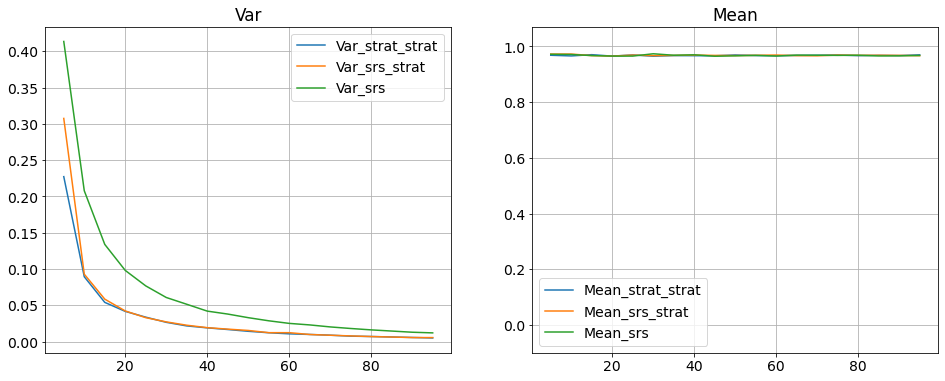

In [11]:
np.random.seed(45)

strat1 = np.random.normal(0, 1, 100)
strat2 = np.random.normal(2, 1, 100)

sample_sizes = np.arange(5, 100, 5)

res = []
for sample_size in tqdm(sample_sizes):
    d = run_calc_vars([strat1, strat2], sample_size=sample_size, n_iter=10000, show=False)
    res.append(d)
    
df = pd.DataFrame(res, index=sample_sizes)
plot_mean_var(df)

На графике видно, что дисперсия случайного сэмплирования всегда выше.  
А дисперсия стратифицированного сэмплирования всегда ниже.

При увеличении размера выборки стратифицированная дисперсия примерно равна дисперсии при постстратификации

### Построим зависимость дисперсии от величины отличия средних между стратами

100%|███████████████████████████████████████████| 51/51 [01:25<00:00,  1.68s/it]


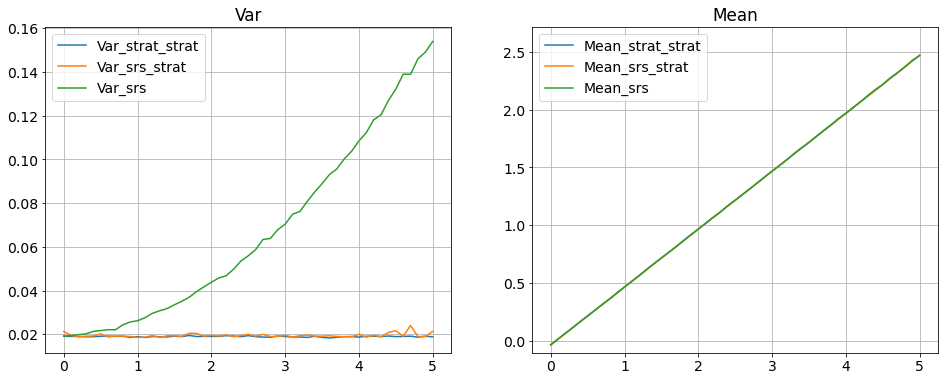

In [12]:
np.random.seed(45)

sample_size = 40

strat1 = np.random.normal(0, 1, 100)
strat2 = np.random.normal(0, 1, 100)

mean_deltas = np.linspace(0, 5, 51)

res = []
for mean_delta in tqdm(mean_deltas):
    d = run_calc_vars([strat1, strat2 + mean_delta], sample_size=sample_size, n_iter=10000, show=False)
    res.append(d)
    
df = pd.DataFrame(res, index=mean_deltas)
plot_mean_var(df)

При росте различий между стратами дисперсия случайного сэмплирования растет, а стратифицированного - нет

### Оценим ошибки первого и второго рода

In [13]:
def get_confidence_interval(mu, std):
    z = stats.norm.ppf(0.975)
    return mu - z * std, mu + z * std

def dot_in_interval(lb, rb, dot=0):
    return lb <= dot <= rb

mu = 100
weights = [0.5, 0.5]
first_type_errors_srs = []
first_type_errors_strat = []

for _ in tqdm(range(10_000)):
    strat1 = np.random.normal(mu, 100, 1000)
    strat2 = np.random.normal(-mu, 100, 1000)
    all_data = np.concatenate([strat1, strat2]) + 5
    
    std_srs = (np.var(all_data) / len(all_data)) ** 0.5
    std_strat = ((weights[0] * np.var(strat1) + weights[1] * np.var(strat2)) / len(all_data)) ** 0.5
    
    ci_srs = get_confidence_interval(np.mean(all_data), std_srs)
    ci_strat = get_confidence_interval(np.mean(all_data), std_strat)
    
    first_type_errors_srs.append(~dot_in_interval(*ci_srs, 0))
    first_type_errors_strat.append(~dot_in_interval(*ci_strat, 0))
    
print(np.mean(first_type_errors_srs))
print(np.mean(first_type_errors_strat))
    

100%|███████████████████████████████████| 10000/10000 [00:04<00:00, 2371.17it/s]

0.2962
0.6058


## Пример оценки AB-теста

In [14]:
# Загрузка данных

URL = 'https://raw.githubusercontent.com/statistics-datasets/kc/main/'
filename = 'sem3_data.csv'

df = pd.read_csv(URL + filename)
df

,group,ОС,age,inapp_prev_week,inapp
0,pilot,android,22,0,0
1,pilot,android,18,0,0
2,pilot,android,38,0,0
3,pilot,android,29,0,0
4,pilot,ios,39,0,0
...,...,...,...,...,...
1995,control,android,27,0,0
1996,control,android,33,0,0
1997,control,ios,37,0,0
1998,control,ios,37,150,50


In [15]:
df['group'].value_counts()

pilot      1000
control    1000
Name: group, dtype: int64

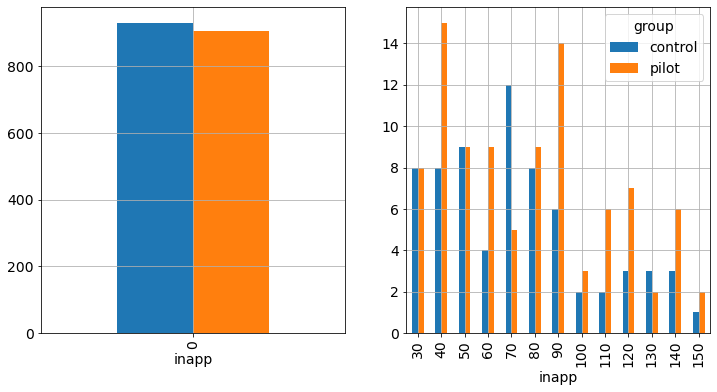

In [16]:
# Функция построения гистограммы покупок во время эксперимента
# Нулевые покупки отдельно, т.к. их гораздо больше
def plot_inapp(df, feature, group):
    """
    feature - какой признак строит
    group - по какому признаку делаем группировку
    """
    
    df_inapp_0 = df[df[feature] == 0]
    df_inapp_not0 = df[df[feature] > 0]
    
    fig, (ax1, ax2)= plt.subplots(1, 2, figsize=(12, 6))
    
    # Имитация hue в pandas.plot()
    df_inapp_0.groupby([feature, group], as_index=False)['age'].count() \
        .pivot(index=feature, columns=[group], values='age') \
        .plot.bar(stacked=False, ax=ax1, grid=True, legend=False)
    
    df_inapp_not0.groupby([feature, group], as_index=False)['age'].count() \
        .pivot(index=feature, columns=[group], values='age') \
        .plot.bar(stacked=False, ax=ax2, grid=True)
    
plot_inapp(df, 'inapp', 'group')

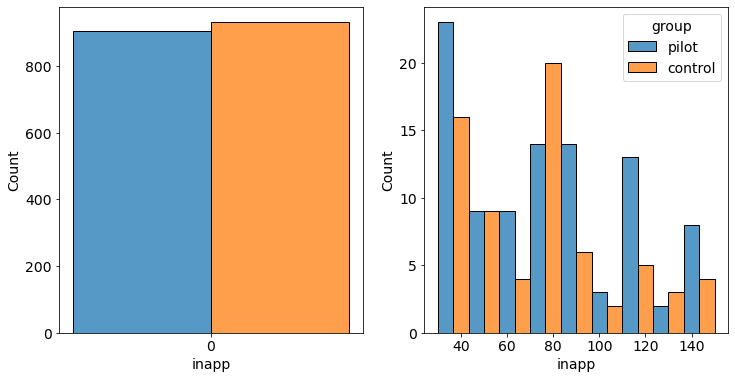

In [17]:
# Функция построения гистограммы покупок во время эксперимента
# Нулевые покупки отдельно, т.к. их гораздо больше
def plot_inapp(df, feature, group):
    """
    feature - какой признак строит
    group - по какому признаку делаем группировку
    """
    
    df_inapp_0 = df[df[feature] == 0]
    df_inapp_not0 = df[df[feature] > 0]
    
    fig, (ax1, ax2)= plt.subplots(1, 2, figsize=(12, 6))
    
    sns.histplot(df_inapp_0, x=feature, hue=group, multiple='dodge', ax=ax1, legend=False)
    ax1.set_xticks([0])
    
    sns.histplot(df_inapp_not0, x=feature, hue=group, multiple='dodge', ax=ax2)
        
plot_inapp(df, 'inapp', 'group')

In [18]:
df.groupby('group').agg(**{
    'inapp_mean': ('inapp', 'mean'),
    'inapp_std': ('inapp', 'std'),
    'inapp_sum': ('inapp', 'sum'),
})

,inapp_mean,inapp_std,inapp_sum
group,,,
control,5.01,20.253644,5010
pilot,7.36,25.057100,7360


In [19]:
stats.ttest_ind(df[df['group'] == 'pilot']['inapp'].values, df[df['group'] == 'control']['inapp'].values)

Ttest_indResult(statistic=2.3065075655928977, pvalue=0.021184160406364526)

<AxesSubplot:xlabel='ОС'>

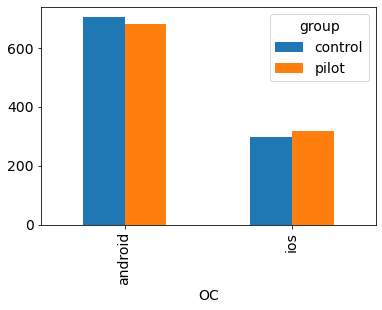

In [20]:
# Построим распределения по другим признакам
df.groupby(['group', 'ОС'], as_index=False)['age'].count() \
    .pivot(index='ОС', columns=['group'], values='age') \
    .plot.bar()

<AxesSubplot:xlabel='ОС', ylabel='count'>

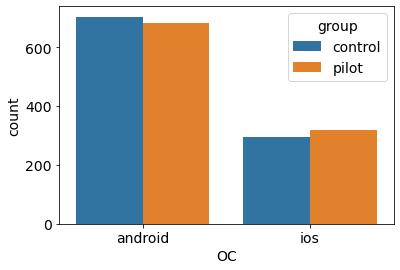

In [21]:
# Тоже самое в seaborn:
df_agg_ = (
    df.groupby(['group', 'ОС'])[['inapp']].count()
    .rename(columns={'inapp': 'count'}).reset_index()
)
sns.barplot(x='ОС', y='count', hue='group', data=df_agg_)

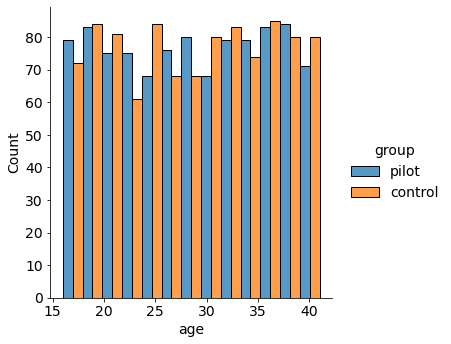

In [22]:
# Гистограмма с разделением на группы
sns.displot(df, x='age', hue='group', multiple='dodge')

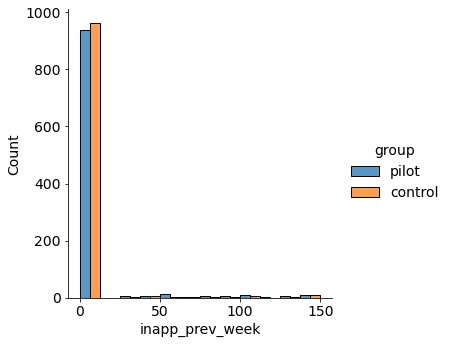

In [23]:
# Гистограмма с разделением на группы
sns.displot(df, x='inapp_prev_week', hue='group', multiple='dodge')

 Видно, что до эксперимента в пилотной группе было меньше нулевых покупок, т.е. пилотная группа была более активна.

In [24]:
def calc_strat_mean(df, strat_column, target_column, weights):
    df_g = df.groupby(strat_column).agg(**{
        'strat_mean': (target_column, 'mean')
    })
    
    # Нажно проследить, чтобы множители были отсортированы по названиям страт
    return np.sum(df_g['strat_mean'].values * weights)

In [25]:
# Добавляю колонку со стратой
df['strat'] = (df['inapp_prev_week'] > 0).astype(int)
df_pilot = df[df['group'] == 'pilot']
df_control = df[df['group'] == 'control']

mean_simple_pilot = df_pilot['inapp'].mean()
mean_simple_control = df_control['inapp'].mean()
diff_simple = mean_simple_pilot - mean_simple_control

print(f"{mean_simple_pilot = :.4f}, {mean_simple_control = :.4f}, {diff_simple = :.4f}")

weights = df['strat'].value_counts(normalize=True).sort_index()
mean_strat_pilot = calc_strat_mean(df_pilot, 'strat', 'inapp', weights)
mean_strat_control = calc_strat_mean(df_control, 'strat', 'inapp', weights)
diff_strat = mean_strat_pilot - mean_strat_control

print(f"{mean_strat_pilot = :.4f}, {mean_strat_control = :.4f}, {diff_strat = :.4f}")


mean_simple_pilot = 7.3600, mean_simple_control = 5.0100, diff_simple = 2.3500
mean_strat_pilot = 6.3898, mean_strat_control = 5.8606, diff_strat = 0.5292


После стратификации эффект сократился в несколько раз с 2,35 до 0,53

In [26]:
# Стратифицированный бутстрап
def strat_bootstrap(df, strat_column):
    dfs = []
    for strat in df[strat_column].unique():
        df_cur = df[df[strat_column] == strat]
        df_strat = df_cur.sample(frac=1, replace=True)
        dfs.append(df_strat)
    return pd.concat(dfs)

In [27]:
n_iter = 1000

means_diff_simple = []
means_diff_strat = []
for _ in tqdm(range(n_iter)):
    df_pilot_simple = df_pilot.sample(frac=1, replace=True)
    df_control_simple = df_control.sample(frac=1, replace=True)
    mean_simple_pilot = df_pilot_simple['inapp'].mean()
    mean_simple_control = df_control_simple['inapp'].mean()
    means_diff_simple.append(mean_simple_pilot - mean_simple_control)
    
    df_pilot_strat = strat_bootstrap(df_pilot, 'strat')
    df_control_strat = strat_bootstrap(df_control, 'strat')
    mean_strat_pilot = calc_strat_mean(df_pilot_strat, 'strat', 'inapp', weights)
    mean_strat_control = calc_strat_mean(df_control_strat, 'strat', 'inapp', weights)
    means_diff_strat.append(mean_strat_pilot - mean_strat_control)

print('Simple:')
mean = np.mean(means_diff_simple)
std = np.std(means_diff_simple)
print(f"Confidence interval: ({mean - 1.96 * std:.3f}, {mean + 1.96 * std:.3f})")
print(f"Mean_simple: {mean:.3f}, Std_simple: {std:.3f}")

print('Strat:')
mean = np.mean(means_diff_strat)
std = np.std(means_diff_strat)
print(f"Confidence interval: ({mean - 1.96 * std:.3f}, {mean + 1.96 * std:.3f})")
print(f"Mean_strat: {mean:.3f}, Std_strat: {std:.3f}")

100%|███████████████████████████████████████| 1000/1000 [00:12<00:00, 83.21it/s]

Simple:
Confidence interval: (0.308, 4.469)
Mean_simple: 2.388, Std_simple: 1.062
Strat:
Confidence interval: (-0.911, 2.045)
Mean_strat: 0.567, Std_strat: 0.754


Простое среднее подтверждает наличие эффекта.  
А вот стратифицированное это не подтверждает, т.к. группы перекошены в сторону пилота.  
Это повод заново провести эксперимент, уделив особое внимание созданию равноценных групп

In [28]:
# Функция стратифицированной дисперсии
def strat_var(df, strat_column, target_column, weights):
    df_g = df.groupby(strat_column).agg(**{
        'strat_var': (target_column, 'var')
    })
    
    # Нажно проследить, чтобы множители были отсортированы по названиям страт
    return np.sum(df_g['strat_var'].values * weights)

In [29]:
mean_simple_pilot = df_pilot['inapp'].mean()
var_simple_pilot = df_pilot['inapp'].var()
mean_simple_control = df_control['inapp'].mean()
var_simple_control = df_control['inapp'].var()
diff_mean_simple = mean_simple_pilot - mean_simple_control
std_simple = (var_simple_pilot / df_pilot.shape[0] + var_simple_control / df_control.shape[0]) ** 0.5
print('Simple:')
print(f"Confidence interval: ({diff_mean_simple - 1.96 * std_simple:.3f}, {diff_mean_simple + 1.96 * std_simple:.3f})")
print(f"Mean_simple: {diff_mean_simple:.3f}, Std_simple: {std_simple:.3f}")

mean_strat_pilot = calc_strat_mean(df_pilot, 'strat', 'inapp', weights)
var_strat_pilot = strat_var(df_pilot, 'strat', 'inapp', weights)
mean_strat_control = calc_strat_mean(df_control, 'strat', 'inapp', weights)
var_strat_control = strat_var(df_control, 'strat', 'inapp', weights)
diff_mean_strat = mean_strat_pilot - mean_strat_control
std_strat = ((var_strat_pilot * weights[0] + var_strat_control * weights[1]) \
             / (df_pilot.shape[0] + df_control.shape[0])) ** 0.5

print('Strat:')
print(f"Confidence interval: ({diff_mean_strat - 1.96 * std_strat:.3f}, {diff_mean_strat + 1.96 * std_strat:.3f})")
print(f"Mean_strat: {diff_mean_strat:.3f}, Std_strat: {std_strat:.3f}")

Simple:
Confidence interval: (0.353, 4.347)
Mean_simple: 2.350, Std_simple: 1.019
Strat:
Confidence interval: (-0.171, 1.230)
Mean_strat: 0.529, Std_strat: 0.357


Стратифицированный t-test также не подтверждает наличия эффекта (аналогично с бутстрапом)

## 4. Обобщающая способность

Сгенерируем 2 распределения, построим их плотности распределения с помощью KDE и оценим площадь пересечения

In [30]:
import statsmodels.api as sm

<AxesSubplot:ylabel='Frequency'>

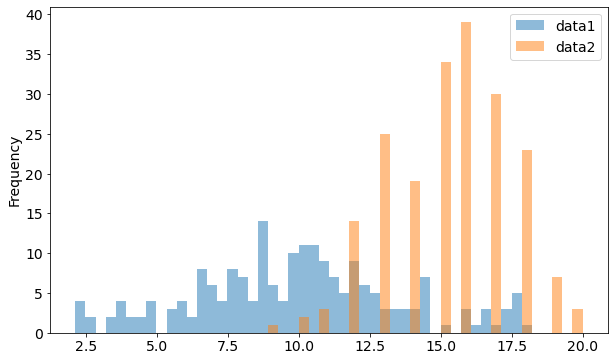

In [31]:
np.random.seed(12)

data1 = np.concatenate([np.random.normal(10, 2, 100), np.random.uniform(2, 18, 100)])
data2 = np.random.binomial(22, 0.7, 200).astype(float)

pd.DataFrame({'data1': data1, 'data2': data2}).plot(kind='hist', bins=50, alpha=0.5, figsize=(10, 6))

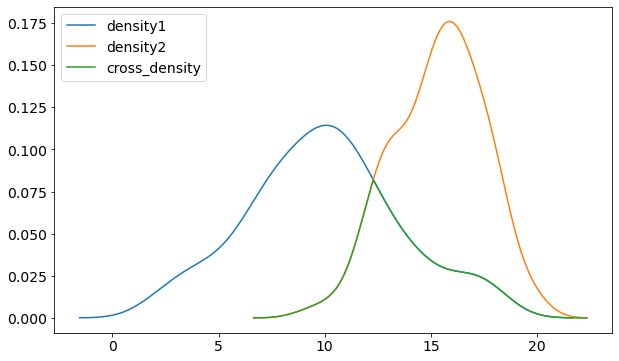

In [50]:
kde1 = sm.nonparametric.KDEUnivariate(data1)
kde1.fit()
support1, density1 = kde1.support, kde1.density # x, y

kde2 = sm.nonparametric.KDEUnivariate(data2)
kde2.fit()
support2, density2 = kde2.support, kde2.density

# Пересечения
# Плотность 1-го распределения, где существует 2-е распределение
density1_in_support2 = kde1.evaluate(support2)
# Минимамльная плотность из 2-х распределений
cross_density = [min(density1_in_support2[i], density2[i]) for i in range(support2.shape[0])]

plt.figure(figsize=(10, 6))
plt.plot(support1, density1, label='density1')
plt.plot(support2, density2, label='density2')
plt.plot(support2, cross_density, label='cross_density')
plt.legend()


In [51]:
def calc_integral(x, y):
    integral = 0
    for i in range(len(x) - 1):
        dx = x[i + 1] - x[i]
        integral += dx * (y[i] + y[i - 1]) / 2
    return integral

cross_integral = calc_integral(support2, cross_density)
cross_integral

0.3487128916997868

Визуально похоже, что площадь пересечения плотностей примерно равна 1 / 3

Зачем это нужно?

Для выбора лучших признаков для разделения по стратам достаточно разницы средних. То есть можно обойтись и без плотности